<a href="https://colab.research.google.com/github/isaachfp/bi-master/blob/master/RN_Trabalho/RedesRecorrentespul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

TensorFlow 1.x selected.


### Importar a base de dados

In [2]:
dataset_train = pd.read_csv('train.csv')
dataset_train.head()

,index,value
0,1974 Jan,3035
1,1974 Feb,2552
2,1974 Mar,2704
3,1974 Apr,2554
4,1974 May,2014


In [3]:
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

### gráfico da série temporal

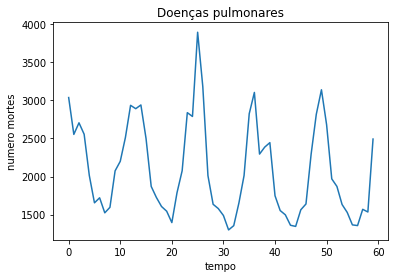

In [4]:
plt.plot(training_set)
plt.xlabel("tempo")
plt.ylabel("numero mortes")
plt.title("Doenças pulmonares")
plt.show()

### Normalização

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [6]:
window = 15
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [7]:
X_train.shape

(45, 15)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
X_train.shape

(45, 15, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [11]:
#hidden_nodes = int(2/3 * (X_train.shape[0] + 1))
#print(hidden_nodes)

### Construção da Rede completa

In [12]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 80)            57920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_______________________________________

### Treinamento

In [13]:
regressor.fit(X_train, y_train, epochs = 250, batch_size = 64)


Epoch 1/250
45/45 [==============================] - 2s 53ms/step - loss: 0.1327
Epoch 2/250
45/45 [==============================] - 0s 942us/step - loss: 0.1015
Epoch 3/250
45/45 [==============================] - 0s 913us/step - loss: 0.0736
Epoch 4/250
45/45 [==============================] - 0s 905us/step - loss: 0.0586
Epoch 5/250
45/45 [==============================] - 0s 916us/step - loss: 0.0506
Epoch 6/250
45/45 [==============================] - 0s 941us/step - loss: 0.0635
Epoch 7/250
45/45 [==============================] - 0s 971us/step - loss: 0.0717
Epoch 8/250
45/45 [==============================] - 0s 929us/step - loss: 0.0538
Epoch 9/250
45/45 [==============================] - 0s 952us/step - loss: 0.0536
Epoch 10/250
45/45 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 11/250
45/45 [==============================] - 0s 968us/step - loss: 0.0477
Epoch 12/250
45/45 [==============================] - 0s 938us/step - loss: 0.0539
Epoch 13/250
45

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [14]:
dataset_test = pd.read_csv('test.csv')
test_pul = dataset_test.iloc[:, 1:2].values

### Construir a estrutura para teste

In [15]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [16]:
predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

### Visualizar os resultados de treino e teste

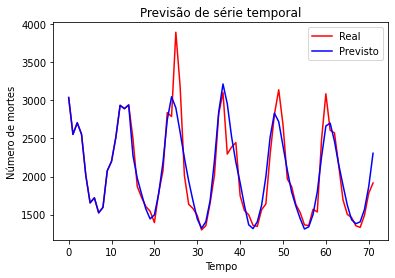

In [17]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Número de mortes')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [18]:
import math
from sklearn.metrics import mean_squared_error,r2_score
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  187.63493992637433


In [19]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  35206.8706811741


In [20]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  6.7635818743022105 %


In [21]:
r2 = r2_score(test_pul,predicted, )
print('R2: ', r2)

R2:  0.8827126055806441
